#Calteh Birds Classification
This Project is done using Google Colaboratory. 1st you have to mount google drive with Colab and place dataset in zipped format on Google drive to access it. This dataset contains birds images of 200 categories. Training images are 5994 & test images are 5794. I have achieved top1 accuracy 77.32% and top5 accuracy 94.30% on test set. This project is done using a ResNet18(pretrained on imagenet).

Next cell is for installation of PyTorch on Google Colab

In [ ]:
# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip drive/Bird/Birds.zip # this line copies the birds dataset from Google drive to Google Colab and also Unzip it for further processing.
# !unzip /content/drive/MyDrive/cis519final/release.zip -d /content/drive/MyDrive/release/

In [2]:
# here are the necessary imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from PIL import Image
import os.path

import shutil

from torch.utils.data import Dataset
from natsort import natsorted

from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models

import math

import torch.optim as optim

plt.ion()   

#Load Data
We will use torchvision and torch.utils.data packages for loading the data. For the training, i have applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also made it sure that the input data is resized to 224x224 pixels as required by the pre-trained networks.

The testing set is used to measure the model's performance on data it hasn't seen yet. For this i have not performed any scaling or rotation transformations, but i had resized and then cropped the images to the appropriate size.

The pre-trained network i have used was trained on the ImageNet dataset where each color channel was normalized separately. For all three sets i have normalized the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

      
# data_dir = '/content/drive/MyDrive/Bird/images copy/'
data_dir = '/content/drive/MyDrive/release/images/'
class Chooser:
    def __init__(self):
        self._counter = 1

    def __call__(self, path):
        self._counter += 1
        return self._counter % 5 != 0

class test_Chooser:
    def __init__(self):
        self._counter = 1

    def __call__(self, path):
        self._counter += 1
        return self._counter % 5 == 0

# image_datasets = {'train' : torchvision.datasets.ImageFolder(data_dir, data_transforms['train'], is_valid_file = Chooser())}
# image_datasets['test'] = torchvision.datasets.ImageFolder(data_dir, data_transforms['test'], is_valid_file = test_Chooser())

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
# class_names = image_datasets['train'].classes


use_gpu = torch.cuda.is_available()


Sizes of training and test datasets

In [ ]:
# dataset_all_sizes = dataset_sizes['train'] + dataset_sizes['test']
# print(dataset_all_sizes)

Labels

In [4]:
labels = open('/content/drive/MyDrive/release/attributes/labels.txt', 'r') 
labels = labels.readlines()
whole_labels = open('/content/drive/MyDrive/release/Tattributes/attributes/labels.txt', 'r') 
whole_labels = whole_labels.readlines()

Attributes

In [5]:
# filename_to_label_id = open('/content/drive/MyDrive/files.txt', 'r') 
filename_to_label_id = open('/content/drive/MyDrive/release/attributes/images-dirs.txt', 'r') 
filename_to_label_id = filename_to_label_id.readlines()
# print(len(filename_to_label_id))
dataset_all_sizes = len(filename_to_label_id)
image_id_2_class_id = {}
image_id_2_class_id_list = np.zeros(len(filename_to_label_id))
# print(image_id_2_class_id_list)
for i, filename in enumerate(filename_to_label_id):
  filename_to_label_id[i] = filename.split()

for i, filename in enumerate(filename_to_label_id):
  id = filename_to_label_id[i][1].split('.')[0]
  image_id_2_class_id[i] = int(id)
  image_id_2_class_id_list[i] = float(int(id) - 1)
# image_id_2_class_id_list =image_id_2_class_id_list
print(image_id_2_class_id_list)
filename_dic = {filename_to_label_id[i][1]: i for i in range(len(filename_to_label_id))}
print(filename_dic)

whole_filename_to_label_id = open('/content/drive/MyDrive/release/Tattributes/attributes/images-dirs.txt', 'r') 
whole_filename_to_label_id = whole_filename_to_label_id.readlines()
# print(len(filename_to_label_id))
whole_dataset_all_sizes = len(whole_filename_to_label_id)
whole_image_id_2_class_id = {}
whole_image_id_2_class_id_list = np.zeros(len(whole_filename_to_label_id))
# print(image_id_2_class_id_list)
for i, filename in enumerate(whole_filename_to_label_id):
  whole_filename_to_label_id[i] = filename.split()

for i, filename in enumerate(whole_filename_to_label_id):
  id = whole_filename_to_label_id[i][1].split('.')[0]
  whole_image_id_2_class_id[i] = int(id)
  whole_image_id_2_class_id_list[i] = float(int(id) - 1)
# image_id_2_class_id_list =image_id_2_class_id_list
print(whole_image_id_2_class_id_list)
whole_filename_dic = {whole_filename_to_label_id[i][1]: i for i in range(len(whole_filename_to_label_id))}
print(whole_filename_dic)

[191. 128.  35. ...  73.   8.  90.]
{'192.Downy_Woodpecker/Downy_Woodpecker_0029_xxx.jpg': 0, '129.Song_Sparrow/Song_Sparrow_0032_2237580089.jpg': 1, '036.Northern_Flicker/Northern_Flicker_0023_3042845058.jpg': 2, '129.Song_Sparrow/Song_Sparrow_0021_15006626.jpg': 3, '131.Vesper_Sparrow/Vesper_Sparrow_0038_2418154276.jpg': 4, '185.Bohemian_Waxwing/Bohemian_Waxwing_0034_138068388.jpg': 5, '143.Caspian_Tern/Caspian_Tern_0008_993513402.jpg': 6, '192.Downy_Woodpecker/Downy_Woodpecker_0025_2844871440.jpg': 7, '053.Western_Grebe/Western_Grebe_0032_1014340835.jpg': 8, '081.Pied_Kingfisher/Pied_Kingfisher_0025_2923147843.jpg': 9, '134.Cape_Glossy_Starling/Cape_Glossy_Starling_0002_3021677625.jpg': 10, '131.Vesper_Sparrow/Vesper_Sparrow_0014_2929246967.jpg': 11, '129.Song_Sparrow/Song_Sparrow_0018_466727756.jpg': 12, '189.Red_bellied_Woodpecker/Red_bellied_Woodpecker_0013_3067110348.jpg': 13, '036.Northern_Flicker/Northern_Flicker_0017_2458047521.jpg': 14, '075.Green_Jay/Green_Jay_0025_20878864

In [6]:
images_attributes = np.zeros((dataset_all_sizes, 288))

old_attribute_id = int(labels[0][2])
old_label_id = int(labels[0][0])
label_id = 0
count = 0
is_present_sum = 0

label_id_count = 0
for label in labels:
  label = label.split()

  label_id = int(label[0])
  attribute_id = int(label[1])
  is_present = int(label[2])
  if int(label[3]) == 2:
    continue
  certainty_id = int(label[3]) if int(label[3]) == 1 else 0.5

  if old_label_id != label_id:
    images_attributes[label_id_count][old_attribute_id] = is_present_sum / count
    count = 0
    is_present_sum = 0
    label_id_count += 1
  elif attribute_id != old_attribute_id:
    images_attributes[label_id_count][old_attribute_id] = is_present_sum / count
    count = 0
    is_present_sum = 0

  count += 1
  is_present_sum += is_present * certainty_id

  old_attribute_id = attribute_id
  old_label_id = label_id

images_attributes[label_id_count][old_attribute_id] = is_present_sum
effective_images_attributes = images_attributes[:,:283]
images_attributes_01 = np.where(images_attributes > 0.5, 1, 0)

print(images_attributes.shape)
print(effective_images_attributes.shape)


(5263, 288)
(5263, 283)


In [7]:
whole_images_attributes = np.zeros((whole_dataset_all_sizes, 288))

old_attribute_id = int(whole_labels[0][2])
old_label_id = int(whole_labels[0][0])
label_id = 0
count = 0
is_present_sum = 0

label_id_count = 0
for label in whole_labels:
  label = label.split()

  label_id = int(label[0])
  attribute_id = int(label[1])
  is_present = int(label[2])
  if int(label[3]) == 2:
    continue
  certainty_id = int(label[3]) if int(label[3]) == 1 else 0.5

  if old_label_id != label_id:
    whole_images_attributes[label_id_count][old_attribute_id] = is_present_sum / count
    count = 0
    is_present_sum = 0
    label_id_count += 1
  elif attribute_id != old_attribute_id:
    whole_images_attributes[label_id_count][old_attribute_id] = is_present_sum / count
    count = 0
    is_present_sum = 0

  count += 1
  is_present_sum += is_present * certainty_id

  old_attribute_id = attribute_id
  old_label_id = label_id

whole_images_attributes[label_id_count][old_attribute_id] = is_present_sum
whole_effective_images_attributes = whole_images_attributes[:,:283]
whole_images_attributes_01 = np.where(whole_images_attributes > 0.5, 1, 0)

print(whole_images_attributes.shape)
print(whole_effective_images_attributes.shape)

(6033, 288)
(6033, 283)


In [8]:
attributes_names = open('/content/drive/MyDrive/release/attributes/attributes.txt', 'r') 
attributes_names = attributes_names.readlines()
attributes_names = attributes_names[:283]

attributes_labels = []
for attributes_name in attributes_names:
  attributes_labels.append(attributes_name.split()[1].split(':')[0])

attribute_splits = [0]
for i in range(len(attributes_labels)-1):
  if attributes_labels[i] != attributes_labels[i+1]:
    attribute_splits.append(i+1)
attribute_splits.append(283)
num_attributes = len(attribute_splits)

onehot_attributes = []
for i, effective_images_attribute in enumerate(effective_images_attributes):
  onehot_attribute = []
  for j in range(len(attribute_splits)-1):
    attribute = effective_images_attribute[attribute_splits[j]:attribute_splits[j+1]]
    max_id = np.argmax(attribute)
    onehot_attribute.append(max_id)
  onehot_attributes.append(onehot_attribute)

onehot_attributes = np.array(onehot_attributes)
print(onehot_attributes.shape)

(5263, 25)


In [9]:
attributes_names = open('/content/drive/MyDrive/release/attributes/attributes.txt', 'r') 
attributes_names = attributes_names.readlines()
attributes_names = attributes_names[:283]

attributes_labels = []
for attributes_name in attributes_names:
  attributes_labels.append(attributes_name.split()[1].split(':')[0])

attribute_splits = [0]
for i in range(len(attributes_labels)-1):
  if attributes_labels[i] != attributes_labels[i+1]:
    attribute_splits.append(i+1)
attribute_splits.append(283)
num_attributes = len(attribute_splits)

whole_onehot_attributes = []
for i, whole_effective_images_attribute in enumerate(whole_effective_images_attributes):
  whole_onehot_attribute = []
  for j in range(len(attribute_splits)-1):
    attribute = whole_effective_images_attribute[attribute_splits[j]:attribute_splits[j+1]]
    max_id = np.argmax(attribute)
    whole_onehot_attribute.append(max_id)
  whole_onehot_attributes.append(whole_onehot_attribute)

whole_onehot_attributes = np.array(whole_onehot_attributes)
print(whole_onehot_attributes.shape)

(6033, 25)


In [ ]:
class_2_attributes = np.zeros((200, 25))
count ={i: 0 for i in range(200)}
for i, class_id in enumerate(image_id_2_class_id_list):
  class_2_attributes[int(class_id)] += onehot_attributes[i]
  count[int(class_id)] += 1

for i in range(len(class_2_attributes)):
  if count[i] == 0:
    continue
  class_2_attributes[i] = np.array(class_2_attributes[i] / count[i], dtype=int)
print(class_2_attributes)

[[4. 2. 3. ... 0. 2. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [2. 1. 3. ... 1. 2. 1.]
 ...
 [3. 2. 1. ... 0. 1. 1.]
 [3. 2. 1. ... 0. 0. 2.]
 [3. 2. 0. ... 3. 2. 3.]]


In [ ]:
# classes_name = open('/content/drive/MyDrive/Bird/images copy/classes.txt', 'r') 
classes_name = open('/content/drive/MyDrive/release/lists/classes.txt', 'r') 
classes_name = classes_name.readlines()

In [10]:
image_dirs = open('/content/drive/MyDrive/release/attributes/images-dirs.txt', 'r') 
image_dirs = image_dirs.readlines()
for i, filename in enumerate(image_dirs):
  image_dirs[i] = filename.split()
image_dirs = [image_dir[1] for image_dir in image_dirs]
print(image_dirs[0])

192.Downy_Woodpecker/Downy_Woodpecker_0029_xxx.jpg


In [11]:
whole_image_dirs = open('/content/drive/MyDrive/release/Tattributes/attributes/images-dirs.txt', 'r') 
whole_image_dirs = whole_image_dirs.readlines()
for i, filename in enumerate(whole_image_dirs):
  whole_image_dirs[i] = filename.split()
whole_image_dirs = [whole_image_dir[1] for whole_image_dir in whole_image_dirs]
print(whole_image_dirs[6032])

091.Mockingbird/Mockingbird_0027_xxx.jpg


In [12]:
unseen_image_dir = []
j=0
i=0

while True:
  if whole_image_dirs[i] != image_dirs[j]:
    unseen_image_dir.append(whole_image_dirs[i])
    i +=1
  else:
    i += 1
    j += 1
  if j== 5263:
    break
    
print(len(unseen_image_dir))

770


dataset and dataloader

onehot-attribute

In [13]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform, filename_dic, images_attributes, phase):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = []

        for image_dir in image_dirs:
          all_imgs.append(image_dir)

        self.total_imgs = natsorted(all_imgs)
        self.filename_dic = filename_dic
        self.images_attributes = images_attributes
        self.phase = phase

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        class_id = (self.total_imgs[idx]).split('.')[0];
        image_id = self.filename_dic[self.total_imgs[idx]]
        attributes = self.images_attributes[image_id]

        if self.phase =='train':
          tensor_image = self.transform['train'](image)
        if self.phase == 'test':
          tensor_image = self.transform['test'](image)

        return tensor_image, attributes, class_id

dataset_train = CustomDataSet(data_dir, data_transforms, filename_dic, onehot_attributes, 'train')
dataset_test = CustomDataSet(data_dir, data_transforms, filename_dic, onehot_attributes, 'test')
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset_train)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=16, 
                                           sampler=train_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=16,
                                                sampler=test_sampler, num_workers=4)

dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['test'] = test_loader

In [14]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform, filename_dic, images_attributes, phase):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = []

        
        for image_dir in unseen_image_dir:
          all_imgs.append(image_dir)
        self.total_imgs = natsorted(all_imgs)
        self.filename_dic = filename_dic
        self.images_attributes = images_attributes
        self.phase = phase

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        class_id = (self.total_imgs[idx]).split('.')[0];
        image_id = self.filename_dic[self.total_imgs[idx]]
        attributes = self.images_attributes[image_id]

        if self.phase =='train':
          tensor_image = self.transform['train'](image)
        if self.phase == 'test':
          tensor_image = self.transform['test'](image)

        return tensor_image, attributes, class_id

unseen_data_dir = '/content/drive/MyDrive/release/Tattributes/images'
dataset_unseen = CustomDataSet(unseen_data_dir, data_transforms, whole_filename_dic, whole_onehot_attributes, 'test')
unseen_loader = torch.utils.data.DataLoader(dataset_unseen, batch_size=16, num_workers=4, shuffle=True)
dataloaders['unseen'] = unseen_loader

#Visualize a few images
Let's visualize a few training images so as to understand the data augmentations.

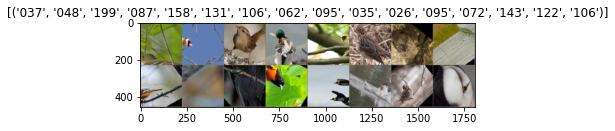

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


for data in dataloaders['train']:
  tensor_image, attributes, class_id  = data
  break



# Make a grid from batch
out = torchvision.utils.make_grid(tensor_image)  
imshow(out, title=[class_id])


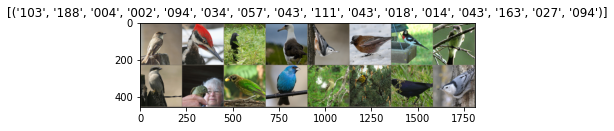

In [ ]:
for data in unseen_loader:
  tensor_image, attributes, class_id  = data
  break

# Make a grid from batch
out = torchvision.utils.make_grid(tensor_image)  
imshow(out, title=[class_id])


In [19]:
dataloader_sizes = {'train': len(dataloaders['train']),'test':len(dataloaders['test']), 'unseen':len(dataloaders['unseen'])}
print(dataloader_sizes)

{'train': 264, 'test': 66, 'unseen': 49}


#Training the model
Now, let's write a general function to train a model. I also have written code to save the best checkpoint within Google drive for using next time

In [15]:
def train_model(model, criterion, optimizer, attribute_splits, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    epoch_loss_train = []
    epoch_acc_train = []
    epoch_loss_test = []
    epoch_acc_test = []
    epoch_loss_unseen = []
    epoch_acc_unseen = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 15)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test', 'unseen']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                loss = 0
                running_correct = 0
                # get the inputs               
                inputs, attributes, _ = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    attributes = Variable(attributes.cuda())
                else:
                    inputs, attributes = Variable(inputs), Variable(attributes)

                # zero the parameter gradients
                if phase == 'train':
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    for i in range(len(attribute_splits)-1):
                        outputs_chunk = outputs[:, attribute_splits[i]:attribute_splits[i+1]]
                        attributes_chunk = attributes[:,i]
                        loss += criterion(outputs_chunk, attributes_chunk)

                        _, pred = torch.max(outputs_chunk, 1)
                        running_correct += torch.sum(pred == attributes_chunk)
                    
                    loss = loss/(len(attribute_splits)-1)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                      outputs = model(inputs)
                      for i in range(len(attribute_splits)-1):
                          outputs_chunk = outputs[:, attribute_splits[i]:attribute_splits[i+1]]
                          
                          attributes_chunk = attributes[:,i]
                          loss += criterion(outputs_chunk, attributes_chunk)

                          _, pred = torch.max(outputs_chunk, 1)
                          running_correct += torch.sum(pred == attributes_chunk)
                      
                      loss = loss/(len(attribute_splits)-1)

                running_loss += loss.item()
                running_corrects += running_correct/attributes.shape[0]/attributes.shape[1]

                # print(running_corrects)
            epoch_loss = running_loss / (dataloader_sizes[phase])
            epoch_acc = running_corrects / (dataloader_sizes[phase])

            if phase == 'train':
                epoch_loss_train.append(epoch_loss)
                epoch_acc_train.append(epoch_acc)
            elif phase == 'test':
                epoch_loss_test.append(epoch_loss)
                epoch_acc_test.append(epoch_acc)
            else:
                epoch_loss_unseen.append(epoch_loss)
                epoch_acc_unseen.append(epoch_acc)              


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model': best_model_wts,'optim':optimizer_ft.state_dict()}
                # torch.save(state,'/content/drive/MyDrive/Bird/point_resnet_best.pth')
                # torch.save(state,'/content/drive/MyDrive/release/best_1219.pth')
                # torch.save(state,'/content/drive/MyDrive/release/best_figure_to_label_directly.pth')
                # torch.save(state,'/content/drive/MyDrive/release/best_figure_to_label_directly_resnet.pth')
                # torch.save(state,'/content/drive/MyDrive/release/onehot_resnet.pth')
                torch.save(state,'/content/drive/MyDrive/release/onehot_resnet_2.pth')
                # torch.save(state,'/content/drive/MyDrive/release/best_figure_to_attri_directly_vgg.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_train, epoch_acc_train, epoch_loss_test, epoch_acc_test, epoch_loss_unseen, epoch_acc_unseen

#Visualizing the model predictions
Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        print(labels)
        print(labels.data)
        print(labels.shape)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        # _, preds = torch.max(outputs.data, 1)
        #print(preds)
        preds = []
        outputs_label = torch.where(outputs > 0.5, torch.tensor(1).cuda(), torch.tensor(0).cuda())
        for i in range(labels.shape[0]):
            min_loss = float('inf')
            for id, att in enumerate(tensor(label_all)):
                loss = criterion(labels[i],att).item() 
                if loss < min_loss:
                    min_loss = loss
                    att_id = id
                preds[i] = att_id

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

#Finetuning the convnet
Load a pretrained Resnet 18 model and reset final fully connected layer.

#Train and evaluate

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [16]:
model_ft_resnet = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_resnet.fc.in_features
model_ft_resnet.fc = nn.Linear(num_ftrs, 283)
# model_ft_resnet.fc = nn.Sequential(nn.Linear(num_ftrs, 288), nn.Sigmoid())      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 288 categories
 
if use_gpu:                                 # if gpu is available then use it
    model_ft_resnet = model_ft_resnet.cuda()       

criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft_resnet.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
model_ft_attri_resnet, epoch_loss_train_attri_resnet, epoch_acc_train_attri_resnet, epoch_loss_test_attri_resnet, epoch_acc_test_attri_resnet, epoch_loss_unseen_attri_resnet, epoch_acc_unseen_attri_resnet = train_model(model_ft_resnet, criterion, optimizer_ft, attribute_splits, num_epochs=60)

Epoch 1/60
---------------
train Loss: 1.4334 Acc: 0.4744
test Loss: 1.4000 Acc: 0.4820
unseen Loss: 1.3650 Acc: 0.5024
Epoch 2/60
---------------
train Loss: 1.3794 Acc: 0.4916
test Loss: 1.3828 Acc: 0.4957
unseen Loss: 1.3591 Acc: 0.5148
Epoch 3/60
---------------
train Loss: 1.3631 Acc: 0.4968
test Loss: 1.3206 Acc: 0.5195
unseen Loss: 1.2765 Acc: 0.5310
Epoch 4/60
---------------
train Loss: 1.3241 Acc: 0.5089
test Loss: 1.2925 Acc: 0.5266
unseen Loss: 1.2330 Acc: 0.5521
Epoch 5/60
---------------
train Loss: 1.3123 Acc: 0.5137
test Loss: 1.2212 Acc: 0.5479
unseen Loss: 1.2022 Acc: 0.5648
Epoch 6/60
---------------
train Loss: 1.2917 Acc: 0.5213
test Loss: 1.2217 Acc: 0.5488
unseen Loss: 1.2113 Acc: 0.5598
Epoch 7/60
---------------
train Loss: 1.2997 Acc: 0.5152
test Loss: 1.2477 Acc: 0.5423
unseen Loss: 1.2286 Acc: 0.5598
Epoch 8/60
---------------
train Loss: 1.3006 Acc: 0.5174
test Loss: 1.1948 Acc: 0.5561
unseen Loss: 1.2059 Acc: 0.5543
Epoch 9/60
---------------
train Loss: 1

ValueError: ignored

In [ ]:
epoch_loss_train_attri_resnet = np.array([1.4334, 1.3794, 1.3631, 1.3241, 1.3123, 1.2917, 1.2997])
epoch_loss_test_attri_resnet = np.array([1.4000, 1.3828, 1.3206, 1.2925, 1.2212, 1.2219, 1.2477])
epoch_loss_unseen_attri_resnet = np.array([1.3650, 1.3591, 1.2765, 1.2330, 1.2022, 1.2113, 1.2286])
epoch_acc_train_attri_resnet = np.array([0.4744, 0.4916, 0.4968, 0.5089, 0.5137, 0.5213, 0.51512])
epoch_acc_test_attri_resnet = np.array([0.4820, 0.4957, 0.5195, 0.5266, 0.5479, 0.5488, 0.5423])
epoch_acc_unseen_attri_resnet = np.array([0.5024, 0.5148, 0.5310, 0.5521, 0.5648, 0.5598, 0.5598])

In [23]:
data_60epoch = open('/content/drive/MyDrive/release/data_60epoch.rtf', 'r') 
data_60epoch = data_60epoch.readlines()

In [43]:
data_60epoch_10 = data_60epoch[9:]
train_loss = []
train_acc = []
test_loss = []
test_acc = []
unseen_loss = []
unseen_acc = []
for i, epoch_ in enumerate(data_60epoch_10):
  if i % 5 == 0 or  i % 5 == 1 :
    continue
  epoch_split = epoch_.split()
  # print(epoch_split)
  epoch_split_4 = epoch_split[4]
  if i % 5 == 2:
    train_loss.append(float(epoch_split[2]))
    train_acc.append(float(epoch_split_4[:6]))
  elif i % 5 ==3:
    test_loss.append(float(epoch_split[2]))
    test_acc.append(float(epoch_split_4[:6]))
  else:
    unseen_loss.append(float(epoch_split[2]))
    unseen_acc.append(float(epoch_split_4[:6]))
  

In [46]:
unseen_loss

[1.365,
 1.3591,
 1.2765,
 1.233,
 1.2022,
 1.2113,
 1.2286,
 1.2059,
 1.2217,
 1.2571,
 1.2181,
 1.2184,
 1.1568,
 1.1999,
 1.1681,
 1.17,
 1.1806,
 1.1643,
 1.1158,
 1.1464,
 1.1624,
 1.1566,
 1.1479,
 1.1284,
 1.1565,
 1.1204,
 1.1434,
 1.1054,
 1.1128,
 1.1055,
 1.1884,
 1.1154,
 1.1055,
 1.1257,
 1.1149,
 1.1435,
 1.1486,
 1.1357,
 1.1026,
 1.1364,
 1.0997,
 1.144,
 1.1391,
 1.1404,
 1.1429,
 1.1492,
 1.143,
 1.1233,
 1.127,
 1.1388,
 1.156,
 1.1616,
 1.1603,
 1.1175,
 1.1774,
 1.1625,
 1.1852,
 1.1975,
 1.1866,
 1.1599]

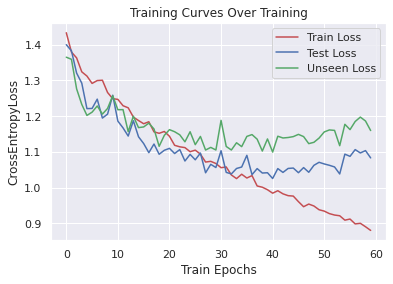

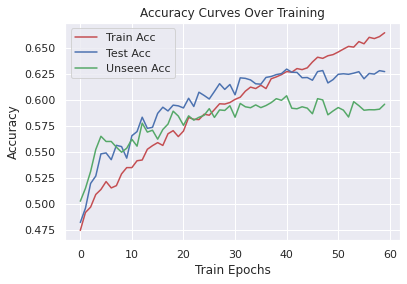

In [47]:
import seaborn as sns
sns.set()

epoch_loss_train_label_resnet_all = []
epoch_loss_test_label_resnet_all = []
# epoch_acc_train_label_resnet_all = []
# epoch_acc_train_label_resnet_all = []
# epoch_loss_train_label_resnet_all = epoch_loss_train_label_resnet
# print(len(epoch_loss_train_label_resnet))

# print(epoch_loss_train_label_resnet[50])
# epoch_loss_test_label_resnet_all = epoch_loss_test_label_resnet
# epoch_loss_test_label_resnet_all.append(epoch_loss_test_label_resnet_2)
# epoch_loss_test_label_resnet_all.append(epoch_loss_test_label_resnet_3)
# epoch_loss_test_label_resnet_all = np.array(epoch_loss_test_label_resnet_all)

plt.plot(np.array(train_loss), color='r', label = 'Train Loss')
plt.plot(np.array(test_loss), color='b', label = 'Test Loss')
plt.plot(np.array(unseen_loss), color='g', label = 'Unseen Loss')
plt.title("Training Curves Over Training")
plt.xlabel('Train Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend()

# print("Azimuth Loss: final accuracy over training set "+str(final_training))
# print("Azimuth Loss: final accuracy over validation set "+str(final_validation))
plt.show()

plt.plot(np.array(train_acc), color='r', label = 'Train Acc')
plt.plot(np.array(test_acc), color='b', label = 'Test Acc')
plt.plot(np.array(unseen_acc), color='g', label = 'Unseen Acc')
plt.title("Accuracy Curves Over Training")
plt.xlabel('Train Epochs')
plt.ylabel('Accuracy')
plt.legend()

# print("Azimuth Loss: final accuracy over training set "+str(final_training))
# print("Azimuth Loss: final accuracy over validation set "+str(final_validation))
plt.show()

In [66]:
pthfile = r'/content/drive/MyDrive/release/onehot_resnet.pth'
net = models.resnet18(pretrained=False)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 283) 
net.load_state_dict(torch.load(pthfile)['model'])
# print(net)
model_ft_attri_resnet = net.cuda()

# overlap

In [ ]:
for data in dataloaders['test']:
  _, attributes, classes = data



In [ ]:
label_all_200 = np.zeros((200, 25))
count_200 ={i: 0 for i in range(200)}
for i, class_id in enumerate(image_id_2_class_id_list):
  label_all_200[int(class_id)] += onehot_attributes[i]
  count_200[int(class_id)] += 1

for i in range(len(label_all_200)):
  if count_200[i] == 0:
    print(i+1)
    continue
  label_all_200[i] = label_all_200[i] / count_200[i]

result = 0
for i, j in zip(attributes, classes):
  k = np.array(i.cpu()).reshape(1,25)
  index_ = np.argmin(np.sum((onehot_attributes - k) ** 2, axis=1))
  if image_id_2_class_id_list[index_]+1 == int(j):
    result += 1

print(result)

2
4
14
18
27
34
41
43
57
64
79
94
103
111
114
116
127
138
142
153
159
163
164
173
188
1039


In [67]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=len(dataset_test),
                                                sampler=test_sampler, num_workers=4)
with torch.no_grad():
  for data in test_loader:
    inputs, attributes, classes = data
    outputs = model_ft_attri_resnet(inputs.cuda())
    preds = torch.zeros((1052,25)).cuda()
    for i in range(len(attribute_splits)-1):
      outputs_chunk = outputs[:, attribute_splits[i]:attribute_splits[i+1]]
      _, pred = torch.max(outputs_chunk, 1)
      preds[:,i] = pred
print(preds.shape)



torch.Size([1052, 25])


In [68]:
unseen_loader = torch.utils.data.DataLoader(dataset_unseen, batch_size=len(dataset_unseen), num_workers=4, shuffle=True)
with torch.no_grad():
  for data in unseen_loader:
    inputs, unseen_attributes, unseen_classes = data
    outputs = model_ft_attri_resnet(inputs.cuda())
    unseen_preds = torch.zeros((770,25)).cuda()
    for i in range(len(attribute_splits)-1):
      outputs_chunk = outputs[:, attribute_splits[i]:attribute_splits[i+1]]
      _, pred = torch.max(outputs_chunk, 1)
      unseen_preds[:,i] = pred
print(unseen_preds.shape)

torch.Size([770, 25])


In [74]:
result = 0

for i, j in zip(unseen_preds, unseen_classes):
  k = np.array(i.cpu()).reshape(1,25)
  a = np.sum((whole_onehot_attributes - k) ** 2, axis=1)
  top_10_index = a.argsort()[:2]
  index_dict = {x: 0 for x in range(200)}
  appearance = 0
  index_c = 0
  for i in top_10_index:
    index_dict[int(whole_image_id_2_class_id_list[i])] += 1
    a = index_dict[int(whole_image_id_2_class_id_list[i])]
    if a > appearance:
      appearance = a
      index_c = i
    if whole_image_id_2_class_id_list[i]+1 == int(j):
      result += 1

  # if whole_image_id_2_class_id_list[index_c]+1 == int(j):
  #   result += 1

print(result)

result = 0

for i, j in zip(unseen_attributes, unseen_classes):
  k = np.array(i.cpu()).reshape(1,25)
  a = np.sum((whole_onehot_attributes - k) ** 2, axis=1)
  top_10_index = a.argsort()[:3]
  index_dict = {x: 0 for x in range(200)}
  appearance = 0
  index_c = 0
  for i in top_10_index:
    index_dict[int(whole_image_id_2_class_id_list[i])] += 1
    a = index_dict[int(whole_image_id_2_class_id_list[i])]
    if a > appearance:
      appearance = a
      index_c = i

  index_ = np.argmin(np.sum((whole_onehot_attributes - k) ** 2, axis=1))
  if whole_image_id_2_class_id_list[index_c]+1 == int(j):
    result += 1

print(result)

85
690


In [75]:
85/770

0.11038961038961038

In [72]:
result = 0

for i, j in zip(preds, classes):
  k = np.array(i.cpu()).reshape(1,25)
  a = np.sum((whole_onehot_attributes - k) ** 2, axis=1)
  top_3_index = a.argsort()[:3]
  index_dict = {x: 0 for x in range(200)}
  appearance = 0
  index_c = 0
  for i in top_3_index:
    index_dict[int(whole_image_id_2_class_id_list[i])] += 1
    a = index_dict[int(whole_image_id_2_class_id_list[i])]
    if a > appearance:
      appearance = a
      index_c = i
    
  index_ = np.argmin(np.sum((whole_onehot_attributes - k) ** 2, axis=1))
  if whole_image_id_2_class_id_list[index_c]+1 == int(j):
    result += 1

print(result)

result = 0
for i, j in zip(attributes, classes):
  k = np.array(i.cpu()).reshape(1,25)
  index_ = np.argmin(np.sum((whole_onehot_attributes - k) ** 2, axis=1))
  if whole_image_id_2_class_id_list[index_]+1 == int(j):
    result += 1

print(result)
# print((np.sum(np.array((outputs == attributes).cpu()), axis=1)))
# for i, j in zip(attributes, classes):
#   k = np.array(i.cpu()).reshape(1,288)
#   index_ = np.argmin(np.sum((label_all_200 - k) ** 2, axis=1))+1
#   if index_ == int(j):
#     result += 1

# print(result)

290
1037


In [73]:
290/1052

0.27566539923954375